P13 Python コード 2.1 pybayes_beta-prior.py
ベルヌーイ分布の成功確率の事前分布の写経

★事前に google colab に登録しておき、google drive の Colab Notebooks フォルダの下に pybayes というフォルダを作っておくこと。

In [28]:
# google colab のディストリビューションを確認しておく。Ubuntu のはず。
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [29]:
# google colab には標準で日本語フォントがインストールされないので、日本語フォントをインストールしておく
!sudo apt install fonts-takao

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-takao is already the newest version (00303.01-2ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [31]:
# 日本語フォントの確認。
!ls /usr/share/fonts/truetype/
# TakaoPGothic.ttf の有無を確認。
!ls /usr/share/fonts/truetype/takao-gothic/

font-awesome		   fonts-japanese-mincho.ttf  takao-gothic
fonts-japanese-gothic.ttf  liberation		      takao-mincho
TakaoGothic.ttf  TakaoPGothic.ttf


In [32]:
# Google Driveにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
# pybayes フォルダへ移動。
cd /content/gdrive/My Drive/Colab Notebooks/pybayes

/content/gdrive/My Drive/Colab Notebooks/pybayes


In [34]:
# pybayes フォルダにいることを確認。
!ls

2.1_pybayes_beta_prior.ipynb	       pybayes_fig_beta_distribution.png
2.2_pybayes_beta_distribution.ipynb    pybayes_fig_beta_prior.png
2.3_pybayes_conjugate_bernoulli.ipynb


In [0]:
# -*- coding: utf-8 -*-

import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# 日本語フォントの設定

from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
  FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
  FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
  FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
else:
  print('この Python コードが対応していない OS を使用しています。')
  sys.exit()

jpfont = FontProperties(fname=FontPath)

In [0]:
# ベルヌーイ分布の成功確率に関するベイズ推論
# ベータ分布の HPD 区間の計算

def beta_hpdi(ci0, alpha, beta, prob):
  def hpdi_conditions(v, a, b, p):
    eq1 = st.beta.cdf(v[1], a, b) - st.beta.cdf(v[0], a, b) - p
    eq2 = st.beta.pdf(v[1], a, b) - st.beta.pdf(v[0], a, b)
    return np.hstack((eq1, eq2))
  return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x

In [0]:
# ベルヌーイ分布の成功確率の事後統計量の計算

def bernoulli_stats(data, a0, b0, prob):
  n = data.size
  sum_data = data.sum()
  a = sum_data + a0
  b = n - sum_data + b0

  mean_pi = st.beta.mean(a, b)
  median_pi = st.beta.median(a, b)
  mode_pi = (a - 1.0) / (a + b - 2.0)

  sd_pi = st.beta.std(a, b)
  ci_pi = st.beta.interval(prob, a, b)
  hpdi_pi = beta_hpdi(ci_pi, a, b, prob)
  stats = np.hstack((mean_pi, median_pi, mode_pi, sd_pi, ci_pi, hpdi_pi))

  stats = stats.reshape((1, 8))
  stats_string = ['平均', '中央値', '再頻値', '標準偏差', '信用区間(下限))', 
                  '信用区間(上限)', 'HPD区間(下限)', 'HPD区間(上限)']
  param_string = ['成功確率 q']
  results = pd.DataFrame(stats, index=param_string, columns=stats_string)
  return results, a, b

In [0]:
# ベルヌーイ分布からのデータの生成

p = 0.25
n = 50
np.random.seed(99)
data = st.bernoulli.rvs(p, size=n)

In [0]:
# 事後統計量の計算

a0 = 1.0
b0 = 1.0
prob = 0.95
results, a, b = bernoulli_stats(data, a0, b0, prob)
#print(results.to_string(float_format='{:,.4f}'.format))

In [52]:
# 事後統計量の表示 (colab ではこちらのほうが整形される)
results

,平均,中央値,再頻値,標準偏差,信用区間(下限)),信用区間(上限),HPD区間(下限),HPD区間(上限)
成功確率 q,0.288462,0.285732,0.28,0.062231,0.17488,0.417448,0.169919,0.411528


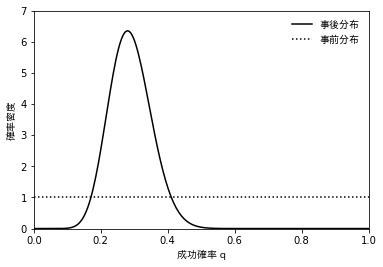

In [54]:
# 事後分布のグラフの作成

fig1 = plt.figure(num=1, facecolor='w')
# コメント：変数 fig1 は何に使われる？

# 成功確率 q を 0 〜 1 の間の 250 等分されたグリッドとして与える。
q = np.linspace(0, 1, 250)
#print("q =", q)

# グラフのプロット
# plt.plot(x, y, option) x:横座標の NumPy配列 y:縦座標の NumPy配列
plt.plot(q, st.beta.pdf(q, a, b), 'k-', label='事後分布')
plt.plot(q, st.beta.pdf(q, a0, b0), 'k:', label='事前分布')

# 横軸と縦軸の範囲の指定
plt.xlim(0, 1)
plt.ylim(0, 7)

# 縦軸と横軸のラベル
plt.xlabel('成功確率 q', fontproperties=jpfont)
plt.ylabel('確率密度', fontproperties=jpfont)

# 凡例
plt.legend(loc='best', frameon=False, prop=jpfont)

# 画像をファイルに保存
plt.savefig('pybayes_fig_bernoulli_posterior.png', dpi=300)

# 画像の表示
plt.show()

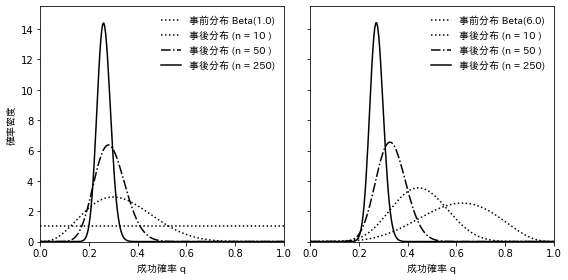

In [62]:
# 事前分布とデータの累積が事後分布の形状に与える影響の可視化

np.random.seed(99)
data = st.bernoulli.rvs(p, size=250)
value_size = np.array([10, 50, 250])
value_a0 = np.array([1.0, 6.0])
value_b0 = np.array([1.0, 4.0])
styles = [':', '-.', '-']
fig2, ax2 = plt.subplots(1, 2, sharey='all', sharex='all',
                         num=2, figsize=(8, 4), facecolor='w')
ax2[0].set_xlim(0, 1)
ax2[0].set_ylim(0, 15.5)
ax2[0].set_ylabel('確率密度', fontproperties=jpfont)

for index in range(2):
  style_index = 0
  a0_i = value_a0[index]
  b0_i = value_b0[index]
  ax2[index].plot(q, st.beta.pdf(q, a0_i, b0_i), color='k',
                  linestyle=styles[style_index],
                  label='事前分布 Beta({0:<3.1f})'.format(a0_i, b0_i))
  for n_j in value_size:
    # style_index += 1
    # [FIX#1]↑この行がここにあるとエラーになるよ
    #print('style_index=', style_index, ' len(styles)=', len(styles))
    sum_data = np.sum(data[:n_j])
    a_j = sum_data + a0_i
    b_j = n_j - sum_data + b0_i
    ax2[index].plot(q, st.beta.pdf(q, a_j, b_j), color='k',
                    linestyle=styles[style_index],
                    label='事後分布 (n = {0:<3d})'.format(n_j))
    ax2[index].set_xlabel('成功確率 q', fontproperties=jpfont)
    ax2[index].legend(loc='best', frameon=False, prop=jpfont)
    style_index += 1
    # [FIX#1]↑ここに移動したよ
plt.tight_layout()
plt.savefig('pybayes_fig_bernoulli_posterior_convergence.png', dpi=300)
plt.show()

In [63]:
# 画像ファイル pybayes_fig_bernoulli_posterior.png と pybayes_fig_bernoulli_posterior_convergence.png が保存されていることを確認。
!ls

2.1_pybayes_beta_prior.ipynb
2.2_pybayes_beta_distribution.ipynb
2.3_pybayes_conjugate_bernoulli.ipynb
pybayes_fig_bernoulli_posterior_convergence.png
pybayes_fig_bernoulli_posterior.png
pybayes_fig_beta_distribution.png
pybayes_fig_beta_prior.png
